# Trajectory dataset preparation

This notebook contains some data-wrangling codes. The goal is to extract from the dataset, trajectories under suitable forms to perform FPCA and distribution learning.

# Preambles

In [1]:
%load_ext autoreload
%autoreload 2

import sys 
sys.path.append("/Users/thinhhoang/Documents/anomaly-detection-ngsim")
# sys.path.append("C:\\Users\\nxf67027\\Documents\\anomaly-detection-ngsim")
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

# Load data from Pickled file

To restore variables, run this code:

In [2]:
import pickle

with open('prepare_trajectories_long.pkl', 'rb') as handle:
    pkl_obj = pickle.load(handle)
    container_t_np = pkl_obj['t']
    container_x_np = pkl_obj['x']
    container_y_np = pkl_obj['y']
    print('Data loaded from file')

num_of_trajs = container_y_np.shape[0]
traj_length = 500

Data loaded from file


# Generation of Transform Basis

## Karhunen-Loeve Transforms

In [3]:
import sklearn
import skfda

%matplotlib inline

Convert the data to appropriate type for the skfda package

In [4]:
fdgrx = skfda.FDataGrid(container_x_np, np.arange(container_x_np.shape[1]))
fdgry = skfda.FDataGrid(container_y_np, np.arange(container_y_np.shape[1]))
# here we don't use the container_t_np vector since we don't want it to mess up the unit

In [5]:
# from skfda.exploratory.visualization import plot_fpca_perturbation_graphs
from skfda.preprocessing.dim_reduction.projection import FPCA

Text(0.5, 1.0, 'Direct KLT basis')

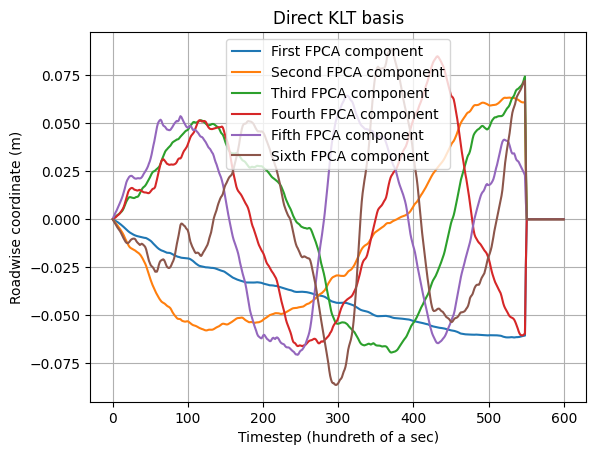

In [6]:
fpca_x = FPCA(n_components=6)
fpca_x.fit(fdgrx)
fpca_x.components_.plot()
plt.xlabel('Timestep (hundreth of a sec)')
plt.ylabel('Roadwise coordinate (m)')
plt.grid(True)
plt.legend(['First FPCA component', 'Second FPCA component', 'Third FPCA component', 'Fourth FPCA component', 'Fifth FPCA component', 'Sixth FPCA component'])
print('')
plt.title('Direct KLT basis')

In [7]:
xcov = fdgrx.cov().data_matrix
xcov = np.reshape(xcov, xcov.shape[1:3])

(0.0, 499.0, 0.0, 499.0)

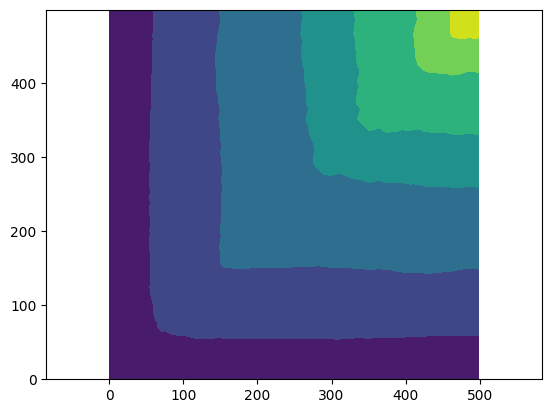

In [8]:
plt.contourf(xcov[:traj_length,:traj_length])
plt.axis('equal')

In [9]:
_, klt_basis = np.linalg.eig(xcov)
klt_basis = np.real(klt_basis[:traj_length,:].T)

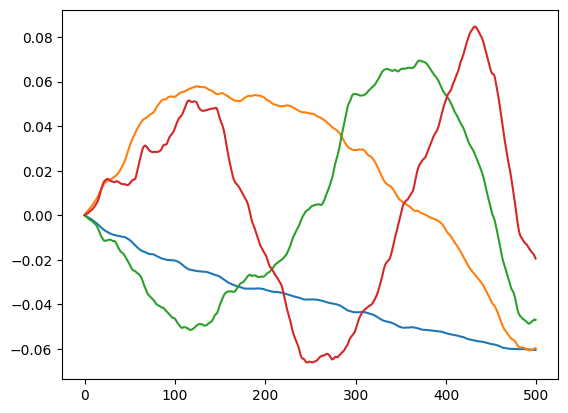

In [10]:
for i in range(4):
    plt.plot(klt_basis[i,:])

## FRSID Transforms

We will also get the FRSID Transform, generated from the afraid_transform.ipynb file, to compare M-terms approximation performance between Karhunen-Loeve Transform and FRSID Transform:

In [11]:
import pickle
with open('frsid_500.basis', 'rb') as f:
    afraid_transform = pickle.load(f)

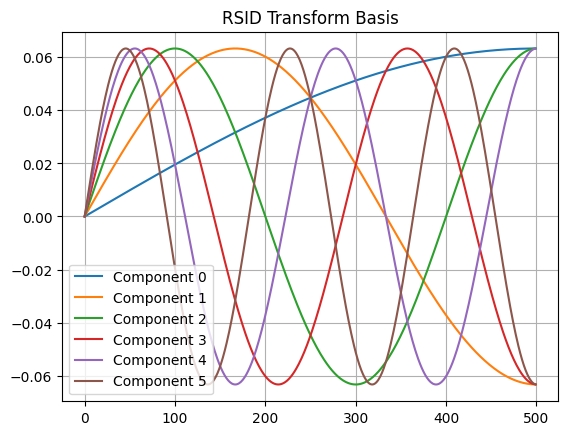

In [12]:
for i in range(6):
    plt.plot(afraid_transform[:,i], label='Component {:d}'.format(i))
plt.grid()
plt.legend()
plt.title('RSID Transform Basis')
afraid_basis = afraid_transform.T 

## Discrete Fourier Transforms

In [13]:
dft_basis = np.zeros((traj_length, traj_length), dtype='complex')
t = np.arange(traj_length)/traj_length
for u in range(dft_basis.shape[0]):
        dft_basis[u,:] = 1/np.sqrt(traj_length) * (np.cos(2*np.pi*u*t) - 1j * np.sin(2*np.pi*u*t))

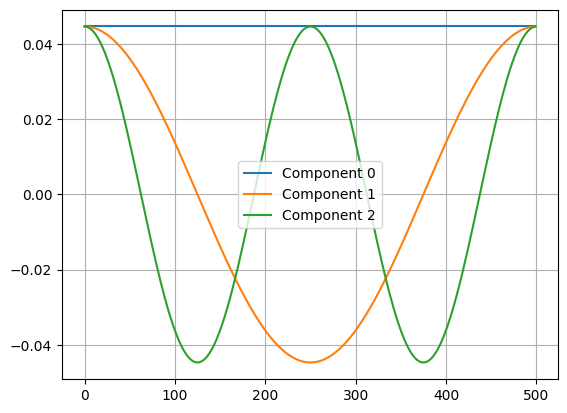

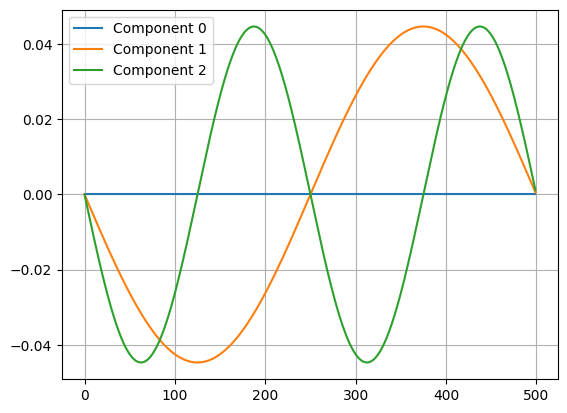

In [14]:
for i in range(3):
    plt.plot(np.real(dft_basis[i,:]), label='Component {:d}'.format(i))
plt.legend()
plt.grid()
plt.figure()
for i in range(3):
    plt.plot(np.imag(dft_basis[i,:]), label='Component {:d}'.format(i))
plt.legend()
plt.grid()

## Discrete Cosine Transform (DCT)

In [15]:
dct_basis = np.zeros((traj_length, traj_length))
t = (2*np.arange(traj_length)+1)/(2*traj_length)
dct_basis[0,:] = np.sqrt(1/traj_length) * np.ones(t.shape)
for u in range(1,dct_basis.shape[0]):
        dct_basis[u,:] = np.sqrt(2/traj_length) * np.cos(np.pi*u*t)

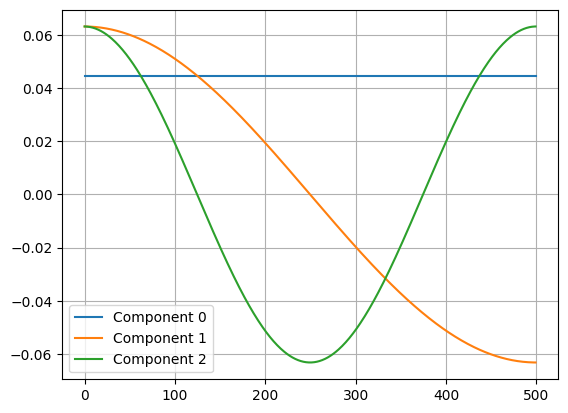

In [16]:
for i in range(3):
    plt.plot(dct_basis[i,:], label='Component {:d}'.format(i))
plt.legend()
plt.grid()

## Benchmark dataset generation

We need the shape of the generated dataset to correctly generate the B-Spline basis

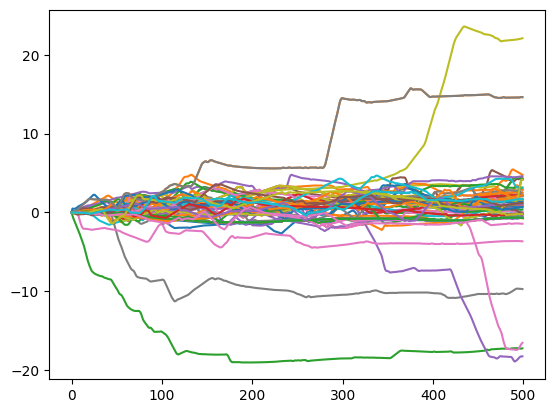

In [17]:
chosen_trajs = np.random.choice(num_of_trajs, size=100)
test_set = container_x_np[chosen_trajs,:500] - (fpca_x.mean_.data_matrix.reshape(-1))[:500]
for i in range(test_set.shape[0]):
    plt.plot(test_set[i,:])

## B-spline basis

Due to B-spline's non-orthogonality, it seems that we have to construct the basis, calculate the coefficients and evaluate the M-terms approximation error at the same time, hence it will be performed in the Bechmarks section.

# Benchmarks

Let's approximate the average error when representing 100 trajectories in each basis: KLT, AFRAID, DFT, DCT

In [18]:
klt_scores = test_set @ klt_basis.T # each row of test_set is an example, each row of klt_basis is an eigenvector
afraid_scores = test_set @ afraid_basis.T
dft_scores = test_set @ dft_basis
dct_scores = test_set @ dct_basis.T

First we should check to make sure that the signal energy is well preserved in both basis.

In [19]:
signal_energy = np.sum(np.square(test_set), axis=1)
print('Max difference between KLT coeffs energy and signal energy: {}'.format(np.max(np.sum(np.square(klt_scores), axis=1) - np.sum(np.square(test_set), axis=1))))
print('Max difference between AFRAID coeffs energy and signal energy: {}'.format(np.max(np.sum(np.square(afraid_scores), axis=1) - np.sum(np.square(test_set), axis=1))))
print('Max difference between DFT coeffs energy and signal energy: {}'.format(np.max(np.sum(np.square(dft_scores), axis=1) - np.sum(np.square(test_set), axis=1))))
print('Max difference between DCT coeffs energy and signal energy: {}'.format(np.max(np.sum(np.square(dct_scores), axis=1) - np.sum(np.square(test_set), axis=1))))

Max difference between KLT coeffs energy and signal energy: -0.009594261051915964
Max difference between AFRAID coeffs energy and signal energy: 283.70399216140504
Max difference between DFT coeffs energy and signal energy: (-56.77176336249809+6.52278231427772e-12j)
Max difference between DCT coeffs energy and signal energy: 2.9103830456733704e-11


Next, we try to compare the average approximation error with 1, 2, 3, ... components allowed to represent.

In [20]:
representation_error_of_klt = np.ones((100, 10))
representation_error_of_oct = np.ones((100, 10))
representation_error_of_dft = np.ones((100, 10))
representation_error_of_dct = np.ones((100, 10))
representation_error_of_bsb = np.ones((100, 10))

representation_error_of_klt_avg = np.ones((10,))
representation_error_of_oct_avg = np.ones((10,))
representation_error_of_dft_avg = np.ones((10,))
representation_error_of_dct_avg = np.ones((10,))
representation_error_of_bsb_avg = np.ones((10,))

for max_components_allowed in range(1,10):
    # KLT
    tail_of_signal_klt = test_set - klt_scores[:,:max_components_allowed] @ klt_basis[:max_components_allowed,:]
    energy_of_signal_tail_klt = np.sum(np.square(tail_of_signal_klt), axis=1)
    proportion_of_energy_klt = energy_of_signal_tail_klt / signal_energy
    representation_error_of_klt[:,max_components_allowed] = proportion_of_energy_klt
    representation_error_of_klt_avg[max_components_allowed] = np.average(proportion_of_energy_klt)

    # AFRAID/OCT
    tail_of_signal_oct = test_set - afraid_scores[:,:max_components_allowed] @ afraid_basis[:max_components_allowed,:]
    energy_of_signal_tail_oct = np.sum(np.square(tail_of_signal_oct), axis=1)
    proportion_of_energy_oct = energy_of_signal_tail_oct / signal_energy
    representation_error_of_oct[:,max_components_allowed] = proportion_of_energy_oct
    representation_error_of_oct_avg[max_components_allowed] = np.average(proportion_of_energy_oct)

    # DFT
    # Because DFT scores are symmetric, 
    dft_scores_sym = np.zeros_like(dft_scores, dtype='complex')
    dft_scores_sym[:,0] = dft_scores[:,0]
    dft_scores_sym[:,1:max_components_allowed+1] = dft_scores[:,1:max_components_allowed+1]
    dft_scores_sym[:,-max_components_allowed:] = np.flip(dft_scores[:,1:max_components_allowed+1].conj(), axis=1)
    # if (max_components_allowed == 3):
    #     raise Exception("Stop this program")
    # tail_of_signal_dft = test_set - np.real(dft_scores[:,:max_components_allowed] @ ((dft_basis.conj().T)[:max_components_allowed,:]))
    tail_of_signal_dft = test_set - np.real(dft_scores_sym @ (dft_basis.conj().T))
    energy_of_signal_tail_dft = np.sum(np.square(tail_of_signal_dft), axis=1)
    proportion_of_energy_dft = energy_of_signal_tail_dft / signal_energy
    representation_error_of_dft[:,max_components_allowed] = proportion_of_energy_dft
    representation_error_of_dft_avg[max_components_allowed] = np.average(proportion_of_energy_dft)

    # DCT
    tail_of_signal_dct = test_set - dct_scores[:,:max_components_allowed] @ dct_basis[:max_components_allowed,:]
    energy_of_signal_tail_dct = np.sum(np.square(tail_of_signal_dct), axis=1)
    proportion_of_energy_dct = energy_of_signal_tail_dct / signal_energy
    representation_error_of_dct[:,max_components_allowed] = proportion_of_energy_dct
    representation_error_of_dct_avg[max_components_allowed] = np.average(proportion_of_energy_dct)

    # B-Spline
    if (max_components_allowed > 3):
        bspline_fda_basis = skfda.representation.basis.BSpline(n_basis = max_components_allowed)
        bspline_basis = np.zeros((max_components_allowed, traj_length))
        fdgrx_test = skfda.FDataGrid(test_set, np.arange(test_set.shape[1]))
        test_set_in_splines = fdgrx_test.to_basis(bspline_fda_basis)
        for i in range(max_components_allowed):
            bspline_basis[i,:] = test_set_in_splines.basis.evaluate(np.arange(traj_length))[i].reshape(-1)
        bspline_scores = fdgrx_test.to_basis(bspline_fda_basis).coefficients
        tail_of_signal_bsb = test_set - bspline_scores @ bspline_basis
        energy_of_signal_tail_bsb = np.sum(np.square(tail_of_signal_bsb), axis=1)
        proportion_of_energy_bsb = energy_of_signal_tail_bsb / signal_energy
        representation_error_of_bsb[:,max_components_allowed] = proportion_of_energy_bsb
        representation_error_of_bsb_avg[max_components_allowed] = np.average(proportion_of_energy_bsb)


In [21]:
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))

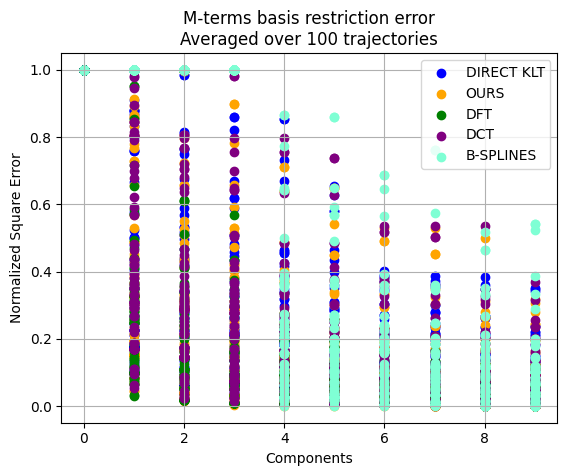

In [22]:
fig, ax = plt.subplots()
for i in range(10):
    plt.scatter(i*np.ones((representation_error_of_klt.shape[0],)), representation_error_of_klt[:,i], c='b', label='DIRECT KLT')
    plt.scatter(i*np.ones((representation_error_of_oct.shape[0],)), representation_error_of_oct[:,i], c='orange', label='OURS')
    plt.scatter(i*np.ones((representation_error_of_dft.shape[0],)), representation_error_of_dft[:,i], c='g', label='DFT')
    plt.scatter(i*np.ones((representation_error_of_dct.shape[0],)), representation_error_of_dct[:,i], c='purple', label='DCT')
    plt.scatter(i*np.ones((representation_error_of_bsb.shape[0],)), representation_error_of_bsb[:,i], c='aquamarine', label='B-SPLINES')
plt.title('M-terms basis restriction error\nAveraged over 100 trajectories')
plt.grid(True)
plt.xlabel('Components')
plt.ylabel('Normalized Squared Error')
legend_without_duplicate_labels(ax)
plt.savefig('xapprox_scatter.pdf', bbox_inches='tight')

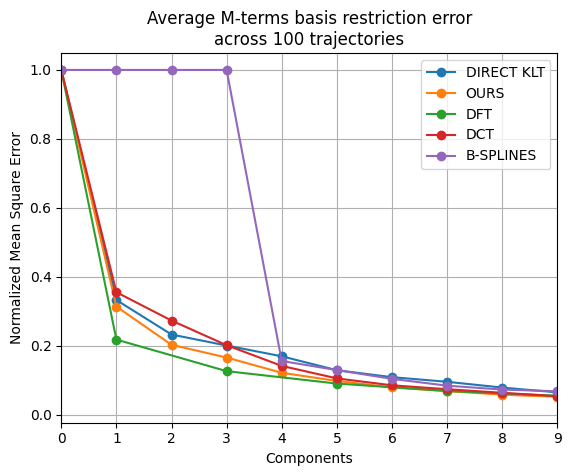

In [26]:
plt.plot(representation_error_of_klt_avg, '-o', label='DIRECT KLT')
plt.plot(representation_error_of_oct_avg, '-o', label='OURS')
plt.plot(np.array([0,1,3,5,7,9,11,13,15, 17]), representation_error_of_dft_avg, '-o', label='DFT')
plt.plot(representation_error_of_dct_avg, '-o', label='DCT')
plt.plot(representation_error_of_bsb_avg, '-o', label='B-SPLINES')
# plt.plot(np.arange(10), 1/np.arange(10)**3, '--', label='Asymptote')
plt.xlim((0,9))
plt.xlabel('Components')
plt.ylabel('Normalized Mean Squared Error')
plt.title('Average M-terms basis restriction error\nacross 100 trajectories')
plt.legend()
plt.grid()
plt.savefig('xapprox_avg.pdf', bbox_inches='tight')

In [24]:
representation_error_of_klt_avg

array([1.        , 0.33304747, 0.23307651, 0.20108644, 0.16997008,
       0.12961038, 0.10944412, 0.09607373, 0.07925937, 0.06547263])

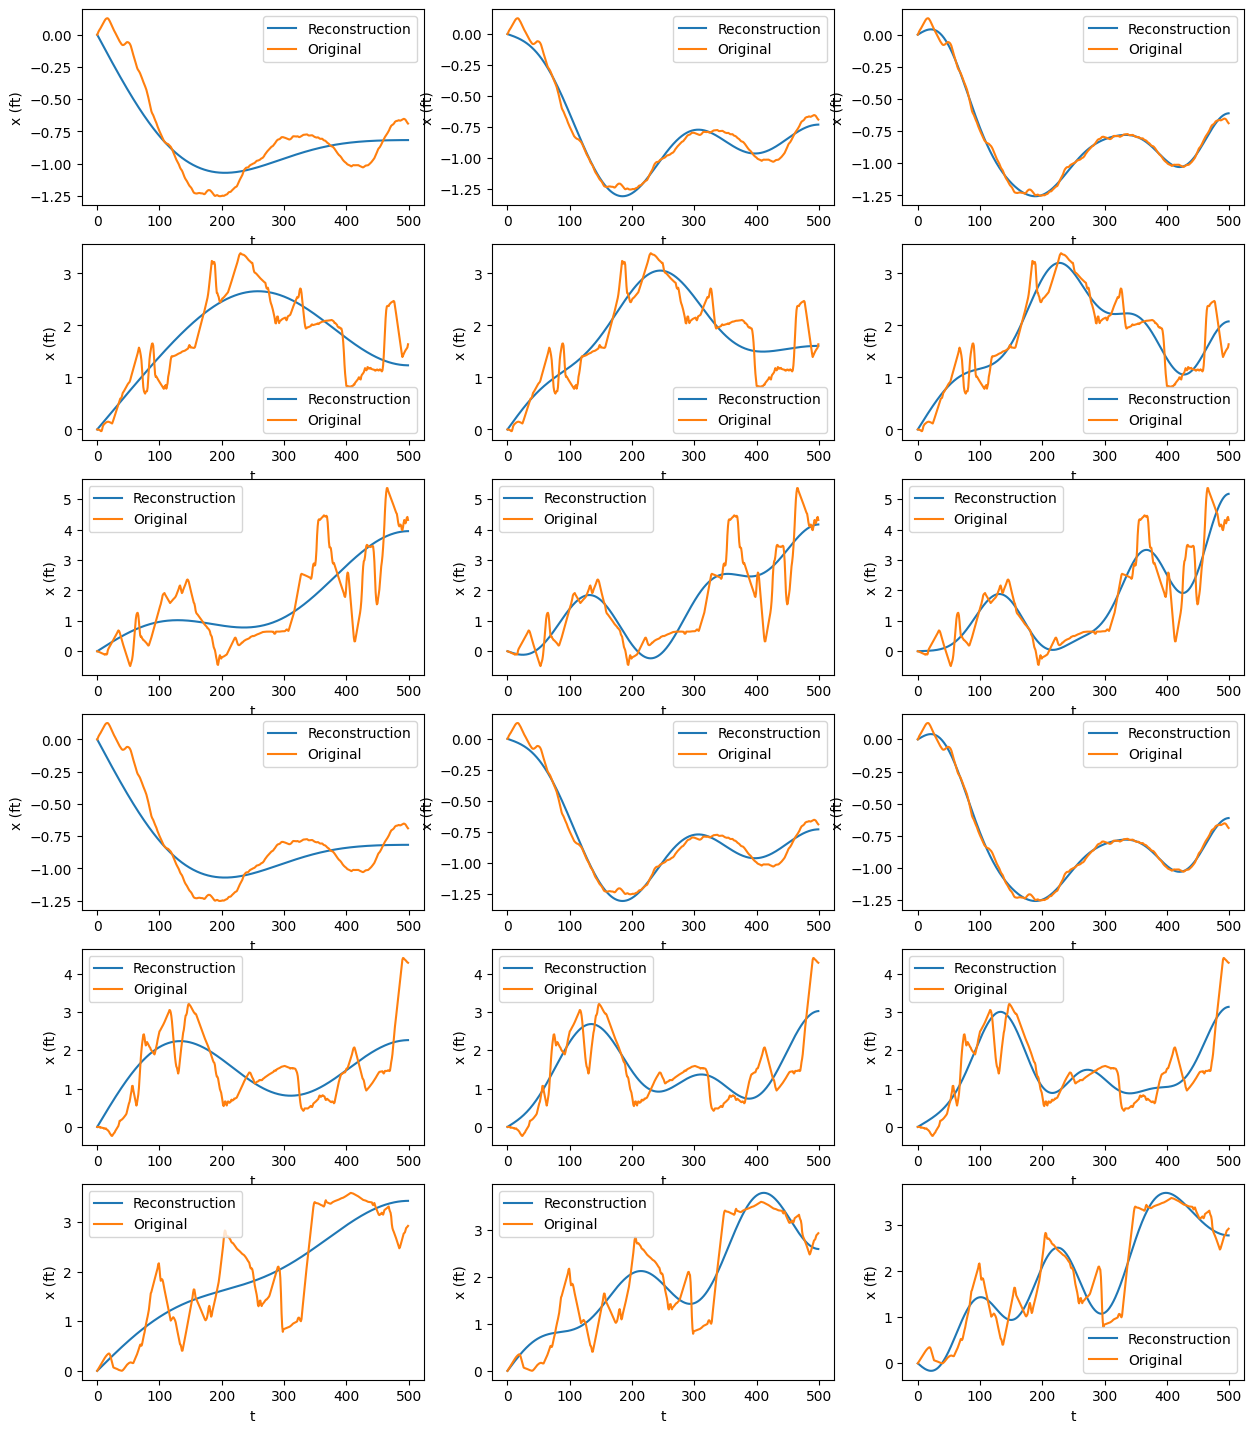

In [25]:
plt.figure(figsize=(15,30))
for i, k in enumerate([3,4,5,6,7,8]):
    plt.subplot(10,3,3*i+1)
    plt.plot(afraid_scores[k,:3] @ afraid_basis[:3,:], label='Reconstruction')
    plt.plot(test_set[k,:], label='Original')
    plt.xlabel('t')
    plt.ylabel('x (ft)')
    plt.legend()

    plt.subplot(10,3,3*i+2)
    plt.plot(afraid_scores[k,:6] @ afraid_basis[:6,:], label='Reconstruction')
    plt.plot(test_set[k,:], label='Original')
    plt.xlabel('t')
    plt.ylabel('x (ft)')
    plt.legend()

    plt.subplot(10,3,3*i+3)
    plt.plot(afraid_scores[k,:9] @ afraid_basis[:9,:], label='Reconstruction')
    plt.plot(test_set[k,:], label='Original')
    plt.xlabel('t')
    plt.ylabel('x (ft)')
    plt.legend()
plt.savefig('approx_x.pdf', bbox_inches='tight')